In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import h3

import time

**Gowalla data exploration**

In [2]:
# edgelist
edf = pd.read_csv("../data/Gowalla_edges.txt", sep="\t")
edf.columns = ["user1", "user2"]

In [3]:
# check-in data
cdf = pd.read_csv("../data/Gowalla_totalCheckins.txt", sep="\t", header=None)
cdf.columns = ["user", "checkin_time", "lat", "lon", "location_id"]

In [4]:
cdf.shape

(6442892, 5)

In [23]:
# are location IDs unique?
print(cdf["location_id"].nunique())
print(cdf[["location_id", "lat", "lon"]].drop_duplicates().shape[0])
print("297 locations have 2 coordinate pairs")

1280969
1281266
297 locations have 2 coordinate pairs


107092  users


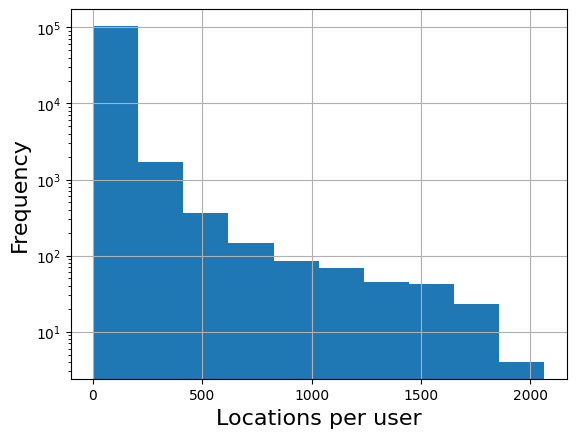

In [6]:
# check location per user
location_per_user = cdf\
    .groupby(["user"])["location_id"]\
    .agg("nunique")\
    .reset_index()\
    .rename(columns={"location_id":"nr_locations"})
print(location_per_user["user"].nunique(), " users")

plt.hist(location_per_user["nr_locations"])
plt.semilogy()
plt.xlabel("Locations per user", size=16)
plt.ylabel("Frequency", size=16)
plt.grid()

In [9]:
cdf["user"].nunique()

107092

In [43]:
location_per_user["nr_locations"].value_counts().head(20)

1     8916
2     6237
3     4929
4     4025
5     3409
6     2991
7     2795
8     2614
9     2467
10    2263
11    2199
12    2178
15    2166
13    2109
17    2057
14    2028
21    2022
20    2022
16    2021
22    1989
Name: nr_locations, dtype: int64

**home detection based on h3 hexagons**

In [61]:
# parameters
h3_resolution = 7
minimum_checkins = 10

In [62]:
# check-in data
cdf = pd.read_csv("../data/Gowalla_totalCheckins.txt", sep="\t", header=None)
cdf.columns = ["user", "checkin_time", "lat", "lon", "location_id"]

In [63]:
def coords_to_point(lat, lon):
    """create Point geometry from lat, lon columns"""
    geometry = [Point(xy) for xy in zip(lon, lat)]
    return geometry

def point_geometry_to_h3(geodf, geometry_col, h3_resolution):
    """create Point geometry from lat, lon columns"""
    h3_col = geodf.apply(lambda r: h3.geo_to_h3(r[geometry_col].y, r[geometry_col].x, h3_resolution), axis=1)
    return h3_col


In [65]:
# filter cdf by input parameters
cdf["nr_locations"] = cdf.groupby(["user"])["location_id"].transform("nunique")
lcdf = cdf[cdf["nr_locations"] >= minimum_checkins]

In [66]:
# construct h3 codes
start_time = time.time()
lcdf["point_geom"] = coords_to_point(lcdf["lat"], lcdf["lon"])
lcdf["h3"] = point_geometry_to_h3(lcdf, geometry_col="point_geom", h3_resolution=h3_resolution)
print("--- %s seconds ---" % round((time.time() - start_time), 3))

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_23534/3823937718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdf["point_geom"] = coords_to_point(lcdf["lat"], lcdf["lon"])


--- 80.331 seconds ---


/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_23534/3823937718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdf["h3"] = point_geometry_to_h3(lcdf, geometry_col="point_geom", h3_resolution=h3_resolution)


In [80]:
# select the most visited h3 by user
def home_table(df):
    """function to select home h3 of users"""
    
    # variables to support selection
    h3_selection = df.groupby(["user", "h3"]).agg(
        locations_in_h3 = pd.NamedAgg("location_id", "nunique"),
        visits_in_h3 = pd.NamedAgg("location_id", "count")
        ).reset_index()

    h3_selection["max_locations_in_h3"] = h3_selection.groupby(["user"])["locations_in_h3"].transform("max")
    h3_selection["max_visits_in_h3"] = h3_selection.groupby(["user"])["locations_in_h3"].transform("max")

    # filter
    return h3_selection

In [81]:
home_table(lcdf)

,user,h3,locations_in_h3,visits_in_h3,max_locations_in_h3,max_visits_in_h3
0,0,872656088ffffff,2,2,23,23
1,0,8726560d2ffffff,1,1,23,23
2,0,872656192ffffff,1,1,23,23
3,0,87265670bffffff,1,1,23,23
4,0,872656720ffffff,1,1,23,23
...,...,...,...,...,...,...
1455318,196577,87195db8bffffff,1,1,1,1
1455319,196578,87195daa4ffffff,17,21,17,17
1455320,196578,87195daa5ffffff,2,2,17,17
1455321,196578,87195daa6ffffff,1,1,17,17


In [83]:
t1 = home_table(lcdf)
t1[t1["locations_in_h3"]==t1["max_locations_in_h3"]]

,user,h3,locations_in_h3,visits_in_h3,max_locations_in_h3,max_visits_in_h3
40,0,87489e346ffffff,23,77,23,23
50,1,87186b4cbffffff,1,1,1,1
51,1,871f91bb2ffffff,1,1,1,1
52,1,871f932ecffffff,1,1,1,1
53,1,871f93710ffffff,1,1,1,1
...,...,...,...,...,...,...
1455315,196577,87195da48ffffff,1,1,1,1
1455316,196577,87195da49ffffff,1,1,1,1
1455317,196577,87195daa4ffffff,1,2,1,1
1455318,196577,87195db8bffffff,1,1,1,1


In [85]:
t1 = home_table(lcdf)
t1[(t1["locations_in_h3"]==t1["max_locations_in_h3"]) & (t1["max_locations_in_h3"] >= 10)]

,user,h3,locations_in_h3,visits_in_h3,max_locations_in_h3,max_visits_in_h3
40,0,87489e346ffffff,23,77,23,23
81,2,8728308a8ffffff,287,296,287,287
216,4,87283082affffff,45,123,45,45
266,7,87489e346ffffff,16,43,16,16
298,9,872656636ffffff,26,46,26,26
...,...,...,...,...,...,...
1455147,196456,87b91682effffff,11,11,11,11
1455197,196489,871f30264ffffff,18,19,18,18
1455249,196514,871951b59ffffff,12,12,12,12
1455292,196561,872834603ffffff,14,35,14,14


In [87]:
t2 = home_table(lcdf)
t2[t2["visits_in_h3"]==t2["max_visits_in_h3"]]

,user,h3,locations_in_h3,visits_in_h3,max_locations_in_h3,max_visits_in_h3
50,1,87186b4cbffffff,1,1,1,1
51,1,871f91bb2ffffff,1,1,1,1
52,1,871f932ecffffff,1,1,1,1
53,1,871f93710ffffff,1,1,1,1
54,1,871f9c426ffffff,1,1,1,1
...,...,...,...,...,...,...
1455313,196577,87195d8cbffffff,1,1,1,1
1455314,196577,87195d8ddffffff,1,1,1,1
1455315,196577,87195da48ffffff,1,1,1,1
1455316,196577,87195da49ffffff,1,1,1,1


In [88]:
t2 = home_table(lcdf)
t2[(t2["visits_in_h3"]==t2["max_visits_in_h3"]) & (t2["max_visits_in_h3"] >= 10)]

,user,h3,locations_in_h3,visits_in_h3,max_locations_in_h3,max_visits_in_h3
369,13,8728d5429ffffff,5,14,14,14
398,13,872a30660ffffff,14,14,14,14
768,25,872830828ffffff,7,10,10,10
847,28,87262cd74ffffff,10,10,10,10
873,28,872656624ffffff,6,10,10,10
...,...,...,...,...,...,...
1454641,196054,8764a4b13ffffff,19,19,19,19
1454765,196138,870894d46ffffff,23,23,23,23
1454891,196193,871f25306ffffff,24,24,24,24
1455147,196456,87b91682effffff,11,11,11,11
